In [16]:
import torch
import torchaudio
import polars
import matplotlib.pyplot as plt

import helpers.input_processor as ip


In [17]:
data_dir = "data/raw_training/training_data/"
df = ip.ingest_data(data_dir)

Reading from .txt files in data/raw_training/training_data/: 100%|██████████| 942/942 [00:00<00:00, 12524.60it/s]


In [18]:
# output metadata of first audio file
metadata = torchaudio.info(data_dir + df['audio_file'][0][0])
print(metadata)

AudioMetaData(sample_rate=4000, num_frames=41152, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [19]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        
    figure.suptitle('Waveform')
    plt.show(block=False)


In [20]:
waveform = torchaudio.load(data_dir + df['audio_file'][0][0])[0]
#plot_waveform(waveform, 4000)

In [21]:
def plot_spectrogram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    fig, axes = plt.subplots(num_channels, 1)
    for c in range(num_channels):
        axes.specgram(waveform[c], Fs=sample_rate)
    fig.suptitle(title)
    plt.show(block=False)

In [22]:
def create_spectrogram(waveform, sample_rate):
    spectrogram = torchaudio.transforms.Spectrogram()(waveform)
    return spectrogram

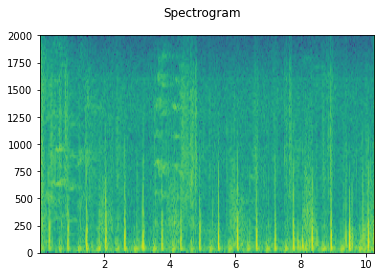

In [23]:
plot_spectrogram(waveform, 4000)

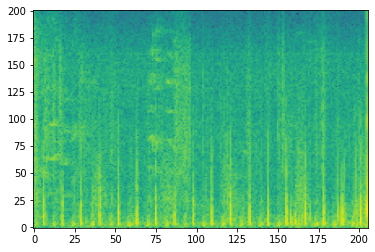

In [24]:
specgram = create_spectrogram(waveform, 4000)
plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), aspect='auto', origin='lower')


## Put the files into a tensor and generate labels for them

In [25]:
# loop through the dataset and create a list of audio paths
audioPaths = []
labels = []
for i in range(len(df)):
    for j in range(len(df['audio_file'][i])):
        audioPaths.append(data_dir + df['audio_file'][i][j])
        # check if there is a murmur at the recording location
        murmur = False
        for k in df['murmur_locations'][i]:
            if k in df['audio_file'][i][j]:
                labels.append(1)
                murmur = True
                break
        if murmur == False:
            labels.append(0)



print("Audio path number: ", len(audioPaths))
print("Label number: ", len(labels))

Audio path number:  3163
Label number:  3163


## Balance The Data

In [26]:
import random
import sys
import copy

# make the positive's and negative's equal
num_pos = 0
num_neg = 0

for i in range(len(labels)):

    if labels[i] == 1:
        num_pos += 1
    else:
        num_neg += 1

balanced_labels = copy.deepcopy(labels)
balanced_audio_paths = copy.deepcopy(audioPaths)


while num_pos != num_neg:
    # get ratio of positive to negative
    ratio = (num_pos / num_neg) * 100.0

    sys.stdout.flush()
    sys.stdout.write("\rRatio: %s" % ratio + "%")

    if num_pos > num_neg:
        foundNeg = False
        while foundNeg == False:
            idx = random.randint(0, len(balanced_labels) - 1)
            if balanced_labels[idx] == 0:
                balanced_labels.append(0)
                balanced_audio_paths.append(balanced_audio_paths[idx])
                foundNeg = True
                num_neg += 1
    else:
        foundPos = False
        while foundPos == False:
            idx = random.randint(0, len(balanced_labels) - 1)
            if balanced_labels[idx] == 1:
                balanced_labels.append(1)
                balanced_audio_paths.append(balanced_audio_paths[idx])
                foundPos = True
                num_pos += 1


Ratio: 99.96246246246247%%

In [27]:
# check how many positive and negative examples are in the dataset
num_pos = 0
num_neg = 0
for i in range(len(balanced_labels)):
    if balanced_labels[i] == 1:
        num_pos += 1
    else:
        num_neg += 1

print("Positive examples: ", num_pos)
print("Negative examples: ", num_neg)
print("Total examples: ", num_pos + num_neg)

print("Percentage of positive examples: ", num_pos / (num_pos + num_neg))

Positive examples:  2664
Negative examples:  2664
Total examples:  5328
Percentage of positive examples:  0.5


In [28]:
# load the audio files and find the length of the longest audio file
max_length = 0
for i in range(len(balanced_audio_paths)):
    waveform = torchaudio.load(balanced_audio_paths[i])[0]
    if waveform.shape[1] > max_length:
        max_length = waveform.shape[1]

print("Max length: ", max_length)

Max length:  258048


### Add lists into dataset

In [31]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class AudioDataset(Dataset):
    def __init__(self, audioPaths, labels):
        self.audioPaths = audioPaths
        self.labels = torch.tensor(labels)
        
        

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        max_length = 258048
        waveform = torchaudio.load(self.audioPaths[idx])[0]
        waveform = waveform
        waveform_padded = torch.nn.functional.pad(waveform, (0, max_length - waveform.shape[1]))
        spectrogram = torchaudio.transforms.Spectrogram()(waveform_padded)
        spectrogram = spectrogram / spectrogram.abs().max()
        return spectrogram, self.labels[idx]

dataset  = AudioDataset(balanced_audio_paths, balanced_labels)

In [69]:
dataset = AudioDataset(audioPaths, labels)
type(dataset[1][1])

/tmp/ipykernel_1400352/1873774759.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels)


torch.Tensor

In [35]:
# simple performance test
import time
start = time.time()
dataset[0]
end = time.time()

speed = (end - start)
print("Speed: ", speed * 1000, "ms")

Speed:  4.990339279174805 ms


In [36]:
print([int(len(dataset) * 0.8), int(len(dataset) * 0.2)])
print((int(len(dataset) * 0.8) + int(len(dataset) * 0.2)))
print(len(dataset))

[4262, 1065]
5327
5328


In [37]:
split_ratio = 0.8
train_size = int(len(dataset) * split_ratio)
test_size = int(len(dataset) - train_size) 
# check if the split is correct
if train_size + test_size != len(dataset):
    # find the difference and correct the split_number
    difference = len(dataset) - (train_size + test_size)
    train_size += difference

print("Split number: ", [train_size, test_size])
print("Split ratio: ", len(dataset))
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator(device='cpu').manual_seed(0))

Split number:  [4262, 1066]
Split ratio:  5328


In [89]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    ## make a convolutional neural network
    def __init__(self):
        super(Net, self).__init__()
        self.sequence = nn.Sequential(
            nn.Conv2d(1, 8,  kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.Flatten(),
        )
    def forward(self, x):
        return self.sequence(x)

net = Net()
net.cuda()

Net(
  (sequence): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Flatten(start_dim=1, end_dim=-1)
  )
)

In [90]:
print(len(train_data))

4262


In [91]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [93]:
import tqdm

trainloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=8, prefetch_factor=8)
testloader = DataLoader(test_data, batch_size=64, shuffle=True)

for epoch in range(3):
    running_loss = 0.0
    epoch_bar = tqdm.tqdm(trainloader)
    epoch_bar.set_description("Epoch %s" % epoch)
    for i, data in enumerate(epoch_bar):
        epoch_bar.set_postfix({"loss": running_loss})
        
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss = loss.item()

    
        


Epoch 2: 100%|██████████| 67/67 [00:05<00:00, 12.05it/s, loss=4.52]
